# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# Bayes sampler and pseudocell creation modules

##### Ver:: A0_V2_1
##### Author(s) : Issac Goh
##### Date : 231002;YYMMDD
### Author notes
- This set of modules first computes a series of learnt attention scores for each cell given a graph input
- These attention scores are then used to sample the data
- The aim of this sampling is to get a good representation of the data given prior knowledge provided from the graph
- We can then construct pseudocells using these sampled data points and the original graph
    
### Features to add
- Add ability to consume anndata zar format for sequential learning
### Modes to run in
- stratified
- unstratified

### Features added:
- Adapative Gaussian kernel pruning

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


# ¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

# Using un-stratified sampling module
- This module provides different attention metrics for local/global node importance measures
- Uses the prior attention scores based on the established graph as priors
- Able to dybnamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained

In [2]:
models = {
    "pan_fetal_wget": "https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl",
    "YS_wget": "https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav",
}

adatas_dict = {
    "pan_fetal_wget": "https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad",
    "YS_wget": "https://app.cellatlas.io/yolk-sac/dataset/23/download",
    "YS_local": "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad",
    "YS_pre_agm": "https://app.cellatlas.io/yolk-sac/dataset/10/download",
    "FLIV_wget": "https://app.cellatlas.io/fetal-liver/dataset/1/download",
    "int_atlas_sub": "/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad",
    "int_atlas_full": "/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad",
}

# setup global params:
# Variable assignment
train_model = True
adata_key = "YS_local"  #'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local
data_merge = False  # read and merge multiple adata (useful, but keep false for now)
model_key = "new_example_model"  #'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local
# dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = False  # #'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False  # should data be normalised?

# setup model parameters:
model_params = {
    #'feat_use': 'LVL3',
    #'train_x_partition' : 'X_scvi', # what partition was the data trained on?
    #'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
    #'var_length' : 7500,
    #'batch_key' : None,
    #'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
    #'max_iter' : 1000, #Increase if experiencing max iter issues
    #'thread_num' : -1,
    #'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
    #'partial_scale' : False, # should data be scaled in batches?
    #'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
    #'batch_correction' : False,
    #'loss':'logloss',
    #'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    # Stratified Bayes sampler kwargs
    "sample_data_knn": True,
    "straify_sampling": False,  # Whether to stratify the sampling by "feat_use" or not
    "knn_key": "neighbors",
    "sampling_rate": 0.1,  # Apply empirical bayes sampling weighted by knn?
    "weight_penalty": "laplacian_SGD_pagerank",  # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
    "iterations": 10,  # How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
    "representation_priority": 0.7,  # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
    "replace": False,  # Allows model to clone cells
    "equal_allocation": False,  # Forces model to create equal representation sets
    "resample_clones": True,  # Reduce the number of clone cells where possible
    "pl_label_entropy": False,
    # Params for SGD-pagerank
    "num_iterations": 1000,  # How many mini-batches to learn
    "mini_batch_size": 10000,  # How large should each mini-batch be
    "full_batch_update_iters": 200,  # How many full batch updates
    "dynamic_hop": True,  # Perform dynamic hop operation?
    "epoch": 5,  # This parameter controls the maxiumum number iterations prior to reconstruction
    "alpha": 0,  # This parameter controls the minimum number of hops to reach an anchor state -- this controls dynamic graph coverage
    "n_jobs": 8,  # this paramter controls the number of parralel jobs to distribute the reconstruction of the connectivity matrix over
}

# A0.2.1 Update:
- For the unstratified sampling module, we should include graph summarisation metrics
- We should loop into epochs for each run of the SGDPR, carrying forward V_opt from previous epochs.
- Let's now consider only updating the local neighborhoods of selected vertices
- Theoretically increasing the neighborhood size of the selected ndoes would bias the next pagerank cycle towards these cells more. 

Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
No pre-rank vector provided, proceeding with randomised intialisation
Converged at iteration 159
Proceeding on to perform fine-tuning across full-batch


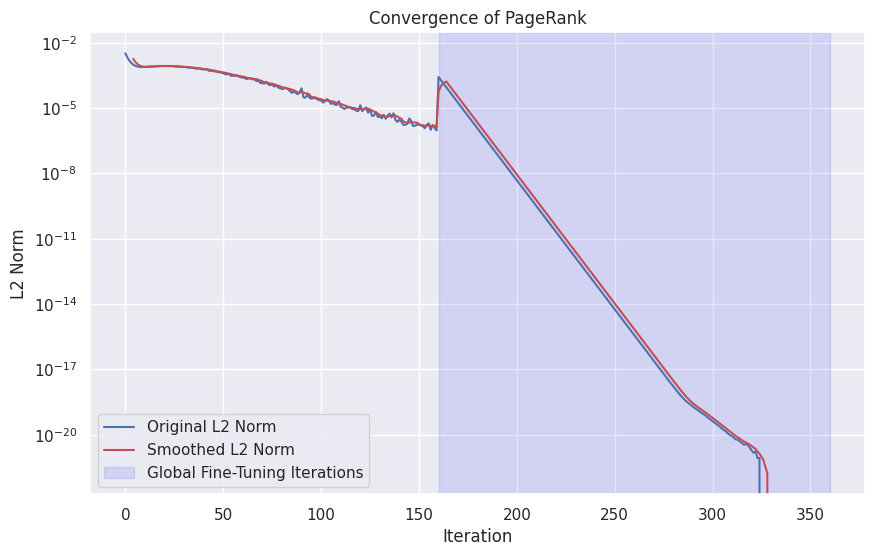

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!
adata_loaded


In [3]:
adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed="r")

if model_params["sample_data_knn"] != False:
    if model_params["straify_sampling"] == True:
        print("Empirical bayes sampling option selected")
        (
            adata_samp,
            indices,
            weights,
        ) = scent.empirical_bayes_balanced_stratified_KNN_sampling(
            adata, **model_params
        )
        scent.plot_sampling_metrics(adata, adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
    else:
        print("Attention-based non-straified sampling selected")
        adata_samp, sample_probs, weights = scent.Attention_based_KNN_sampling(
            adata, **model_params
        )
        adata_samp = adata_samp.to_memory()
print("adata_loaded")

### Removed "feat_use" from model params to demonstrate that non-stratified sampler is independent of labels
- added back in below to show conservation of cell-states

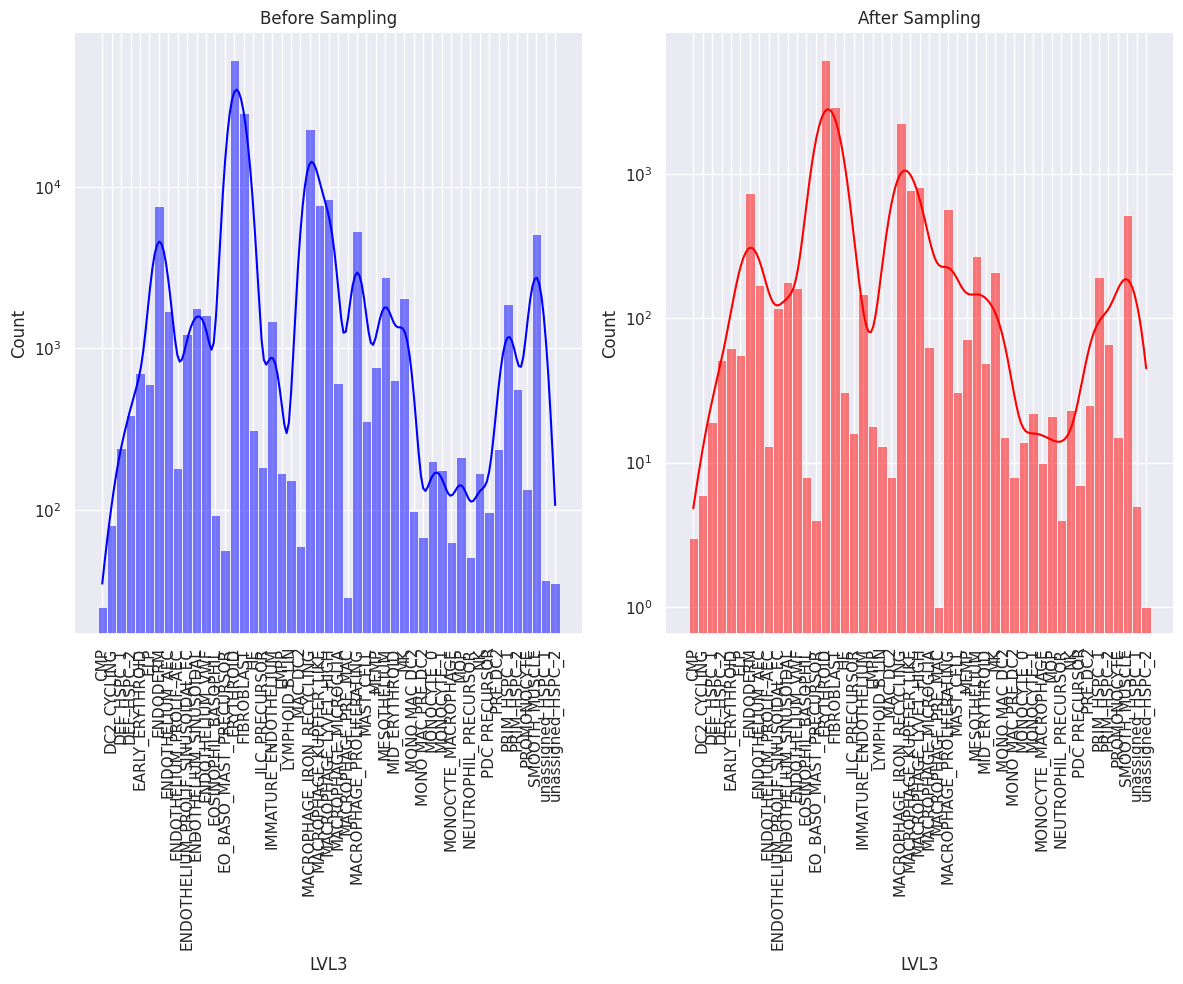

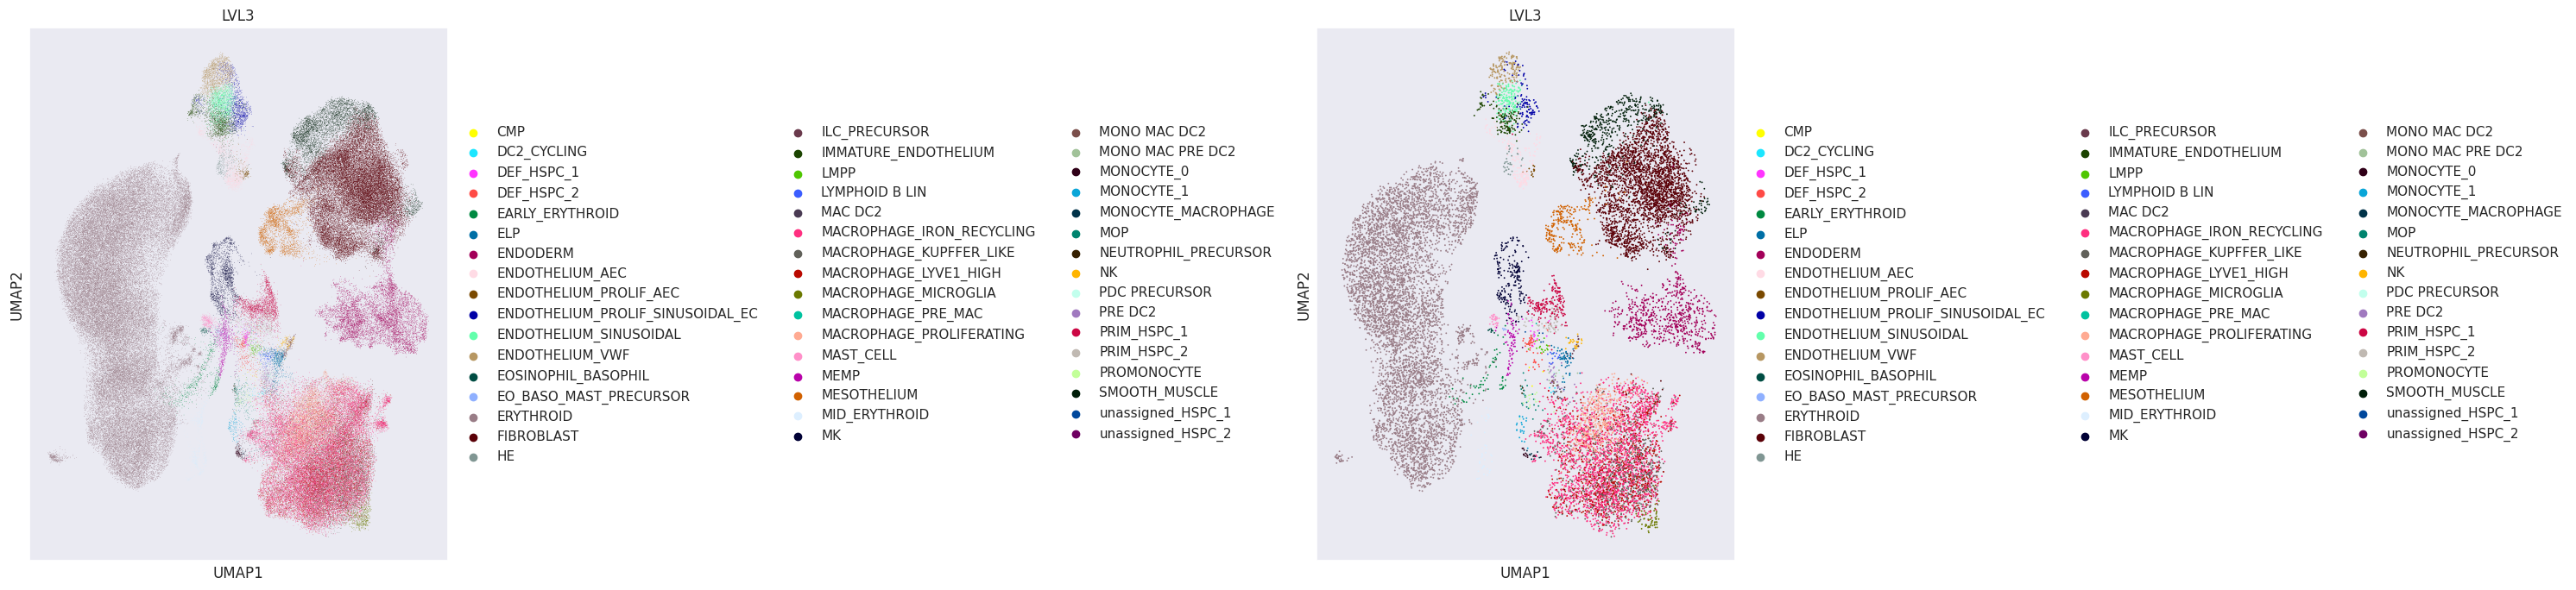

In [4]:
model_params["feat_use"] = "LVL3"
scent.plot_sampling_metrics(adata, adata_samp, **model_params)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30, 7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params["feat_use"], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params["feat_use"], ax=axs[1], show=False)
# Display the plots
plt.tight_layout()
plt.show()

# Show the sampling distribution

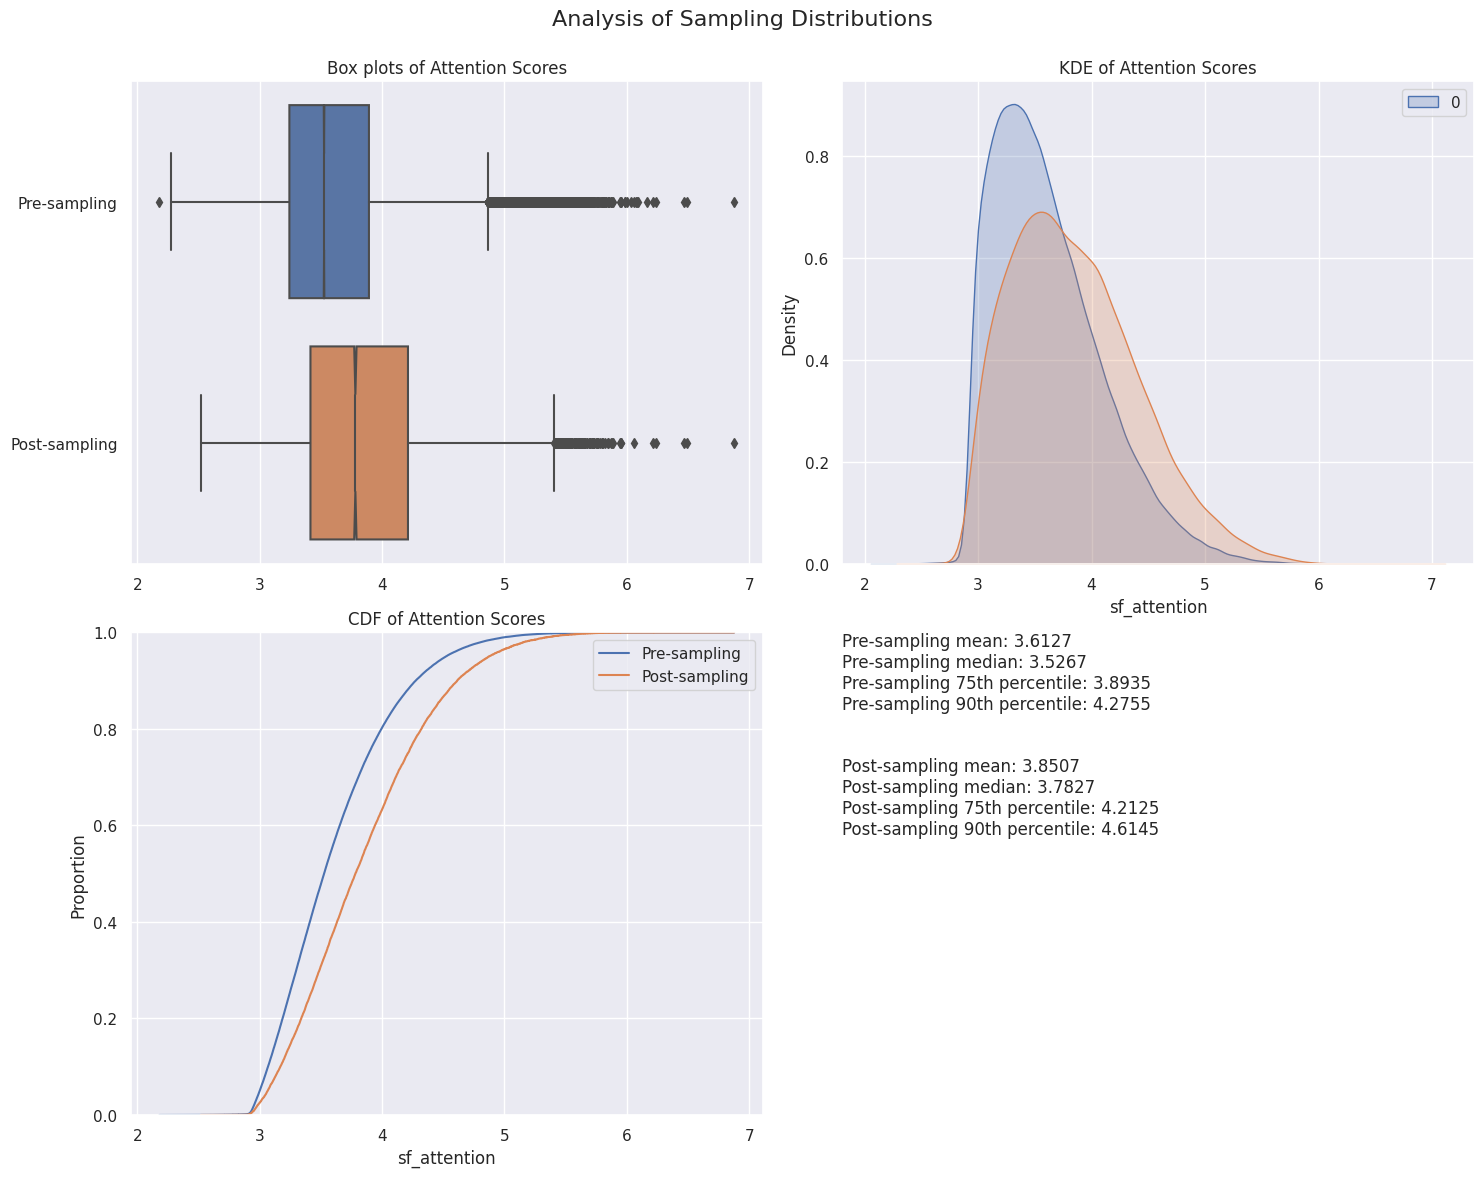

In [5]:
# Extract attention scores
pre_sample_scores = weights["all_weights"]
post_sample_scores = adata_samp.obs["sf_attention"]
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

# Optionally expand neighborhoods to explicitly cover all nodes in graph
- This application adopts a dynamic expansion strategy to recover rare transitional relationships available in the graph
- It applies an adaptive gaussian kernel function to prune the resultant dynamically expanded graph
- This module can be computationally expensive during reconstruction of the graph

#### Simple measure if all cells are connected to minimum 1 pseudocell

- Set anchor states as selected pseudocells
- All cells must be connected to a minimum of alpha pseudostates
- Neighborhood hop performed dynamically


### Workflow:
- Compute naive sampling with attention scores
- Iteratively expand neighborhod until they meet a minimum alpha
- dynamically prune the updated graphs with an adaptive gaussian kernel
- Recompute updated pagerank chunk
- Re-sample and test for connectivity.

## Author module notes:

### A0.2.1 -- Test code for dynamic hop updates
- incoperate parallelisation
- include batch processing for matrix reconstruction
- include efficient matrix multiplication operations

### V0.2.1 Adapative Gaussian kernel pruning
- Post dynamic expansion, we design an adaptive gaussian kernel pruning strategy
- Compute the Gaussian Kernel: For each connection in the matrix, calculate the Gaussian kernel value. The Gaussian kernel typically depends on the distance between nodes and a scaling parameter (like variance).

- Apply the Kernel to the Connectivity Matrix: Multiply the connectivity matrix by the Gaussian kernel values. This operation will adjust the weights of the connections based on the kernel.

- Preserve Connections to Anchor Nodes: Ensure that connections to anchor nodes are not removed or diminished. This might involve setting the kernel value to 1 (or maximum) for these connections.

- Prune Low-Weight Connections: After applying the kernel, prune connections that fall below a certain threshold, which can help in removing weak connections.

###  V0.2.1 Adaptive Pruning notes
- The pruning process is adaptive in the sense that it adjusts the connections in the matrix based on the context (i.e., the distance or similarity between points) rather than applying a uniform threshold. This adaptiveness is primarily achieved through the Gaussian kernel, which gives more weight to closer or more similar nodes and less to those farther away or less similar. Here's how adaptiveness is incorporated:

- Gaussian Kernel: By applying the Gaussian kernel, you scale the weights of the connections based on their distance/similarity. Closer or more similar nodes get higher weights.

- Preserving Anchor Nodes: By ensuring that connections to anchor nodes are not pruned, you adaptively preserve important structures in your data.

- Thresholding: By setting a threshold, you prune away connections that are below a certain level of significance. This threshold can be adaptive too, for example, it could be set relative to the average weight of connections in the matrix.


Epoch: 0
Updating connectivity matrix in chunks
10 compute cores available
Using parallel processing with 8 jobs
Make sure that Python modules winreg, win32api or win32con are installed.
INFO: blas_opt_info:
INFO: blas_armpl_info:
INFO: customize UnixCCompiler
INFO:   libraries armpl_lp64_mp not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blas_mkl_info:
INFO:   libraries mkl_rt not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blis_info:
INFO:   libraries blis not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: openblas_info:
INFO:   libraries openblas not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/u

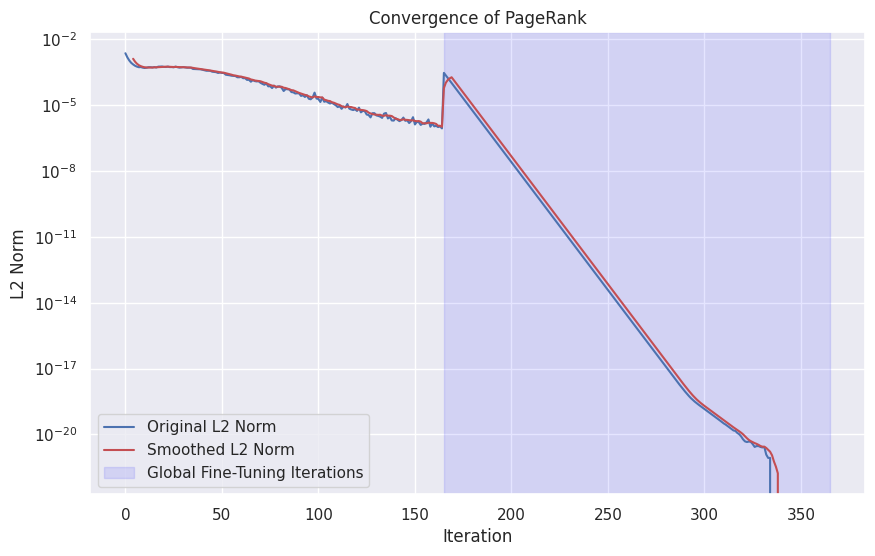

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!


In [6]:
if model_params["dynamic_hop"] == True:
    results = scent.expand_neighborhoods_chunked(
        adata, adata_samp, **model_params
    )  # param_set
    update_mat = results["main_matrix"]
    model_params["init_vect"] = weights["v"]
    # Set the updated neighborhood expansion as main KNN matrix
    adata.obsp[adata.uns[model_params["knn_key"]]["connectivities_key"]] = update_mat

    # Re-run SGD_pgr with updated mat and pre-established v vector
    if model_params["sample_data_knn"] != False:
        if model_params["straify_sampling"] == True:
            print("Empirical bayes sampling option selected")
            (
                adata_samp,
                indices,
                weights,
            ) = scent.empirical_bayes_balanced_stratified_KNN_sampling(
                adata, **model_params
            )
            scent.plot_sampling_metrics(adata, adata_samp, **model_params)
            adata_samp = adata_samp.to_memory()
        else:
            print("Attention-based non-straified sampling selected")
            adata_samp, sample_probs, weights = scent.Attention_based_KNN_sampling(
                adata, **model_params
            )
            adata_samp = adata_samp.to_memory()

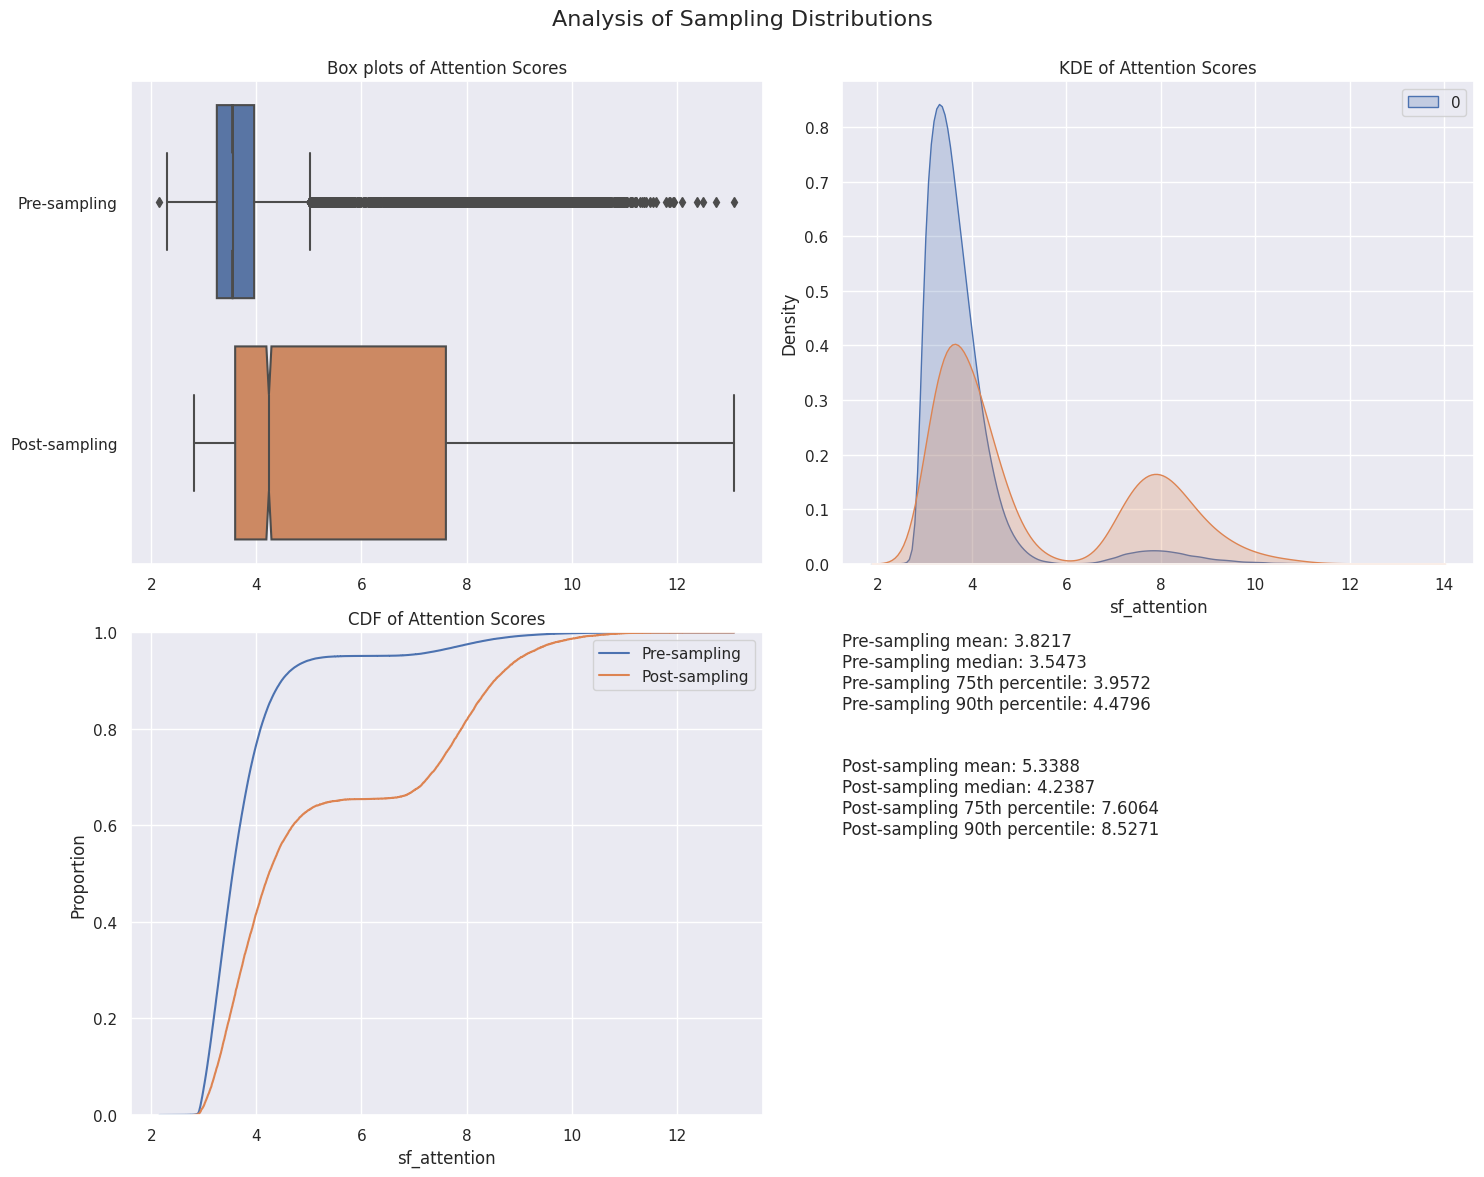

In [7]:
pre_sample_scores = weights["all_weights"]
post_sample_scores = adata_samp.obs["sf_attention"]
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

# Compare sampling bias against Randomised boostrap sampling distribution

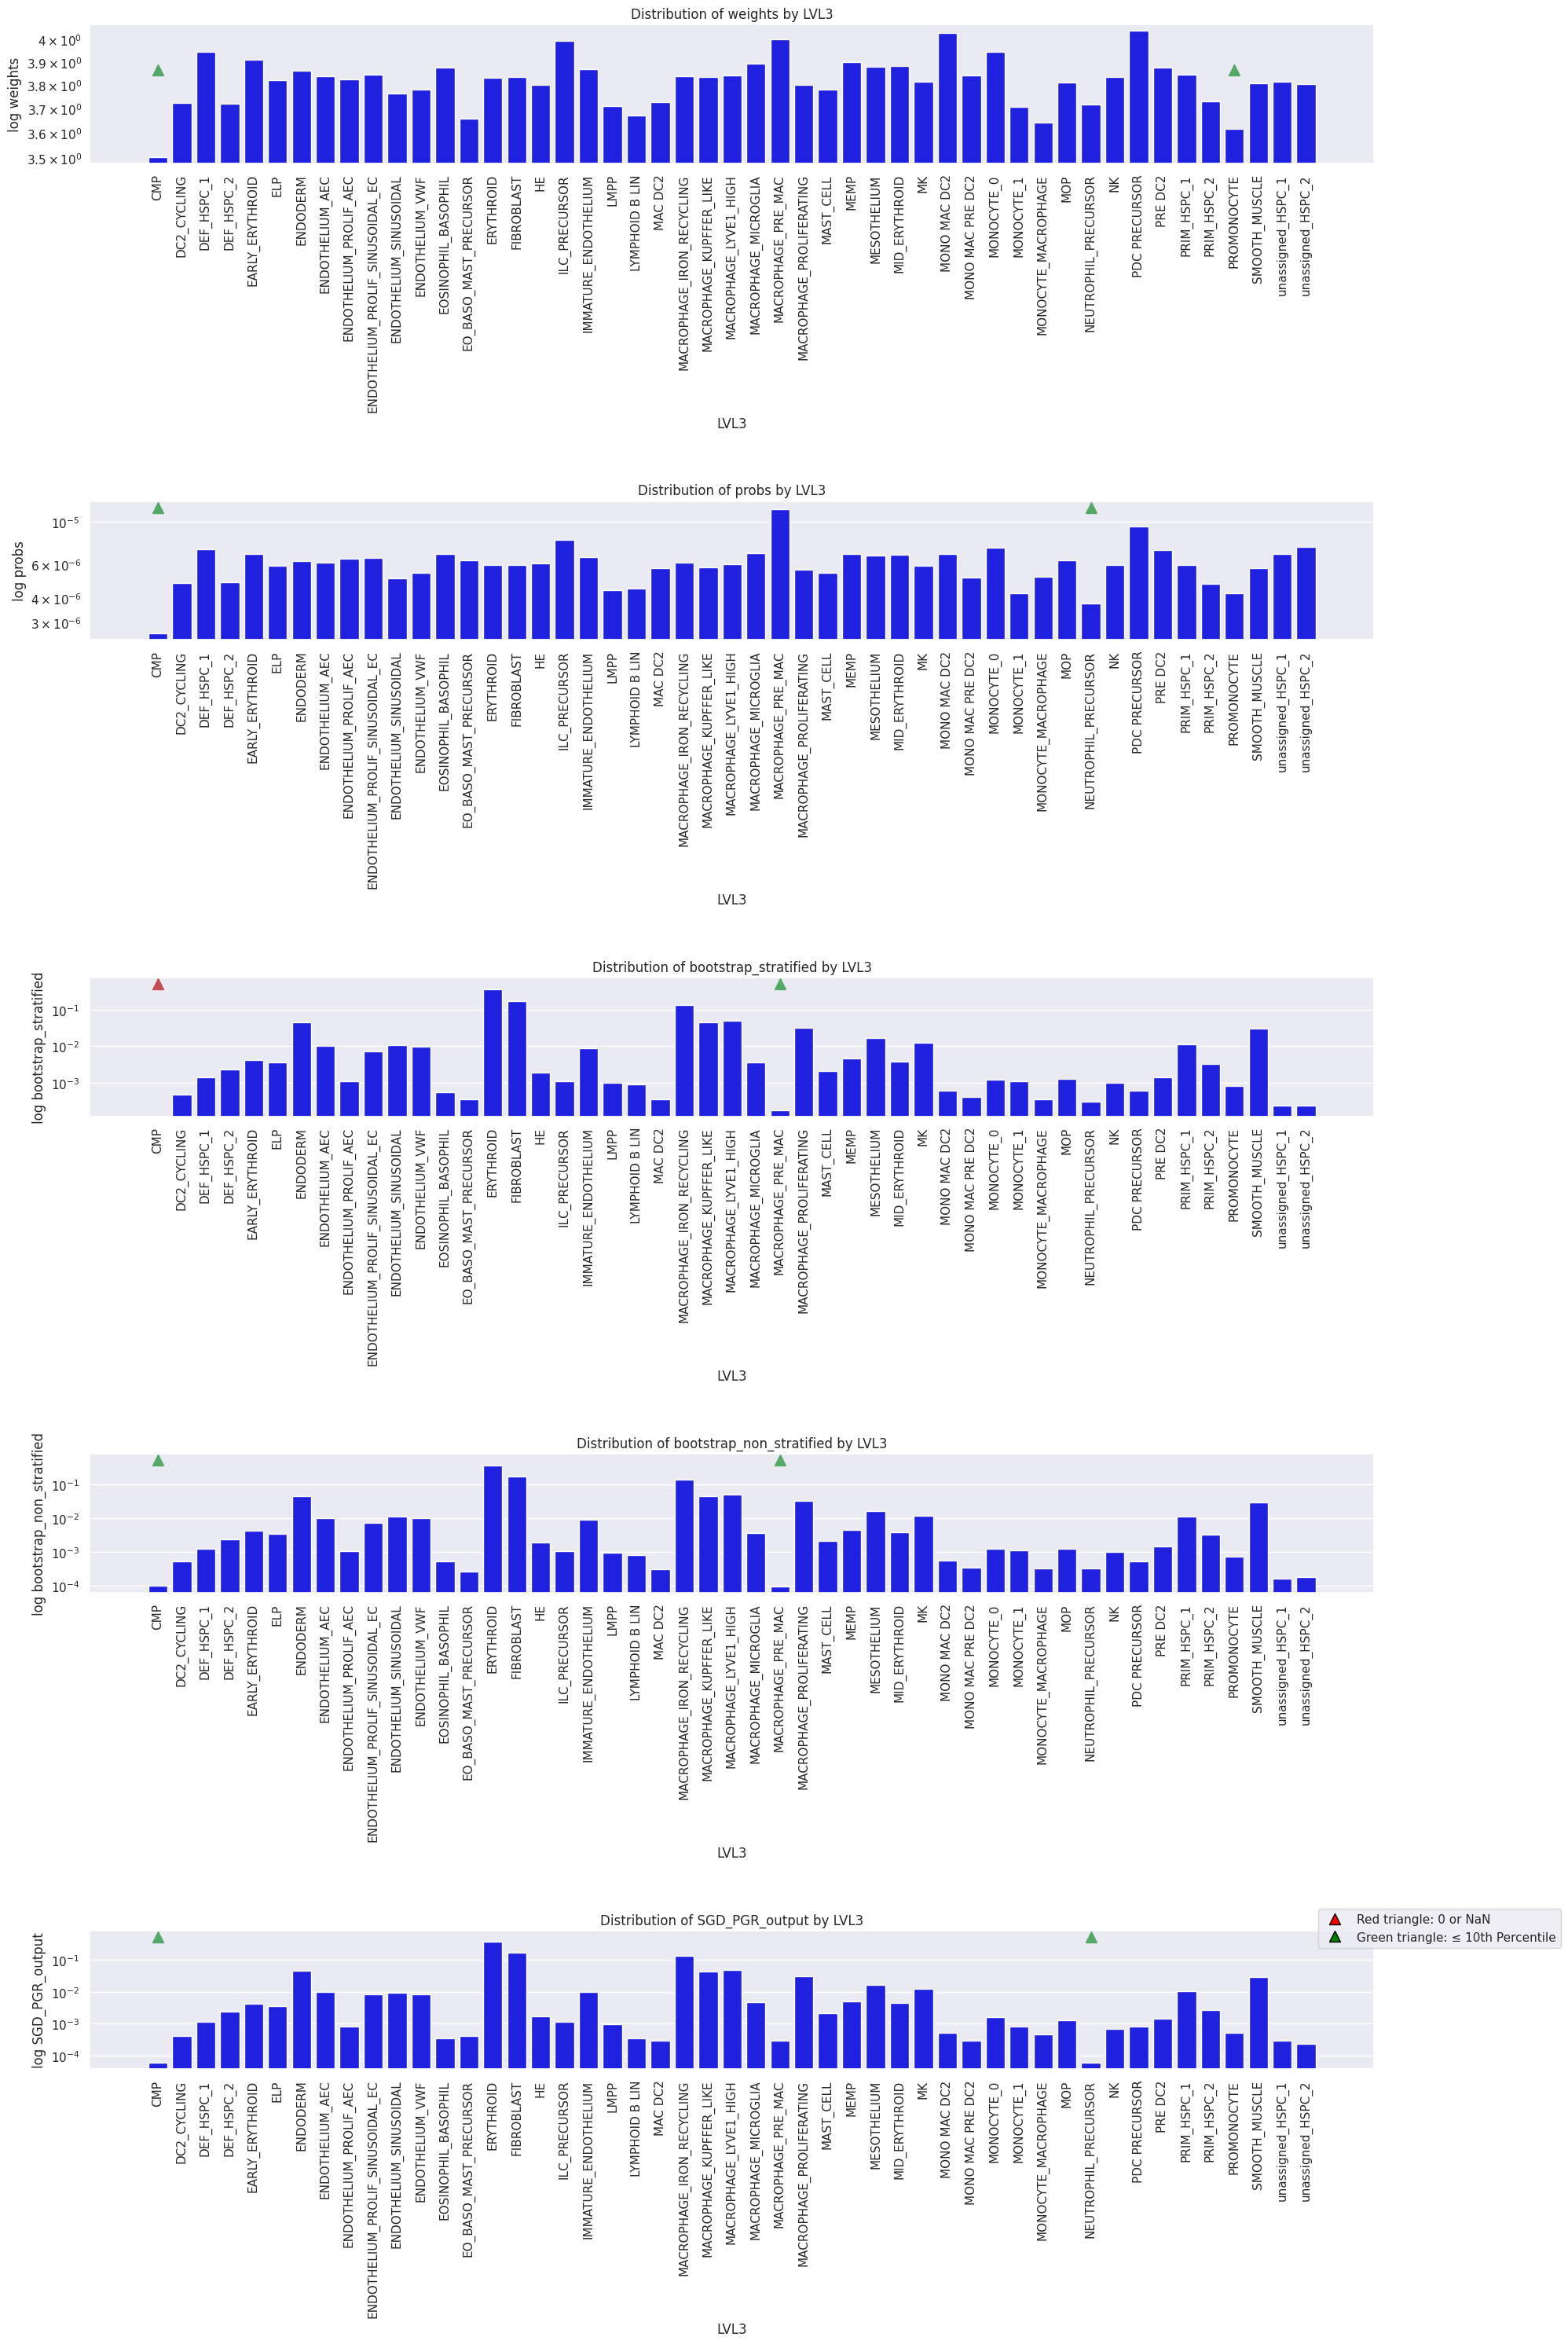

In [10]:
grouping = model_params["feat_use"]
plot_vars = [
    "weights",
    "probs",
    "bootstrap_stratified",
    "bootstrap_non_stratified",
    "SGD_PGR_output",
]

obs = adata.obs.copy()
# Create a randomized sampling
random_sampling_probabilities = scent.compute_sampling_probability(
    obs, grouping, sample_fraction=0.1, n_iterations=1000
)
# Add the SGD_PGR sampled data distribution
samp_obs = adata_samp.obs.copy()
samp_obs = dict(
    samp_obs.groupby(grouping).size() / sum(samp_obs.groupby(grouping).size())
)

obs["weights"] = weights["all_weights"]
obs = obs.iloc[list(sample_probs.keys())]
obs["probs"] = list(sample_probs.values())
obs = obs.groupby(grouping).mean()
# Add random sampling
for key in random_sampling_probabilities.keys():
    column_name = f"bootstrap_{key}"
    obs[column_name] = [
        random_sampling_probabilities[key].get(group, 0) for group in obs.index
    ]

# Handle missing categories and add SGD_PGR sampled data
missing_categories = []
sgd_pgr_output = []

for group in obs.index:
    try:
        sgd_pgr_output.append(samp_obs[group])
    except KeyError:
        missing_categories.append(group)
        sgd_pgr_output.append(None)  # Or any default value you'd prefer, like np.nan

obs["SGD_PGR_output"] = sgd_pgr_output

if missing_categories:
    print(f"Missing categories in samp_obs: {', '.join(missing_categories)}")

scent.plot_grouped_distributions(obs, plot_vars, grouping)

# Neighborhood-Based Pseudobulk Aggregation of anchor node neighborhoods in scRNA-seq Data#

### Methodology for Neighborhood-Based Pseudobulk Aggregation of scRNA-seq Data

#### Update ver A0.1.2 -- 
   - Updated aggregation function to detect backed readings
   - if data is backed, assume large X partition is inevitable & create chunked reads of X for updates

#### Background:
Single-cell RNA sequencing (scRNA-seq) datasets capture diverse biological states across many cells, making it computationally challenging to analyze them directly. Pseudobulk aggregation offers a way to distill this complexity by combining data from multiple cells. This method aggregates cells based on local neighborhoods, ensuring a more biologically meaningful representation. Additionally, it incorporates a normalization step inspired by the scVI model, providing a balanced representation of each cell within its local context.

#### Objective:
To generate pseudobulk gene expression profiles by aggregating cells within neighborhoods defined by a k-nearest neighbors (KNN) connectivity matrix, ensuring that each cell's contribution is fairly represented based on its local context.

#### Method:
Given a scRNA-seq dataset with $( N $) cells and $( G $) genes represented by a matrix $( X $) of dimensions $( N $times G $), and a KNN connectivity matrix $( C $) of dimensions $( N $times N $), we aim to aggregate data in neighborhoods of sampled cells to produce pseudobulk profiles.

1. **Neighborhood Definition**:
For a given sampled cell $( i $), its neighborhood is defined by the non-zero entries in row $( i $) of the KNN connectivity matrix $( C $).

$$ \text{Neighborhood}(i) = \{ j | C_{ij} > 0 \} $$

2. **Local Scaling Factors**:
For each neighborhood associated with a sampled cell \( i \), a scaling factor is computed for every cell in that neighborhood based on the cell's total counts relative to the average counts of cells within that neighborhood.

$$ \text{LocalScalingFactor}(j) = \frac{\sum_{g=1}^{G} X_{jg}}{\frac{1}{|\text{Neighborhood}(i)|} \sum_{n \in \text{Neighborhood}(i)} \sum_{g=1}^{G} X_{ng}} $$

where \( j \) is a cell in the neighborhood of sampled cell \( i \).

3. **Neighborhood Aggregation**:
For each sampled cell \( i \), the pseudobulk profile is generated by aggregating the expression data of its neighborhood cells. The aggregated expression of gene \( g \) for cell \( i \) is given by:

$$ \text{Pseudobulk}_{ig} = \frac{\sum_{j \in \text{Neighborhood}(i)} \text{LocalScalingFactor}(j) \times X_{jg}}{\sum_{j \in \text{Neighborhood}(i)} \text{LocalScalingFactor}(j)} $$

This results in a matrix \( P \) of dimensions \( S \times G \), where \( S \) is the number of sampled cells.


#### Why account for scaling factors by total counts?

1. **Accounting for Differences in Sequencing Depth**: 
   In scRNA-seq experiments, there can be variability in the number of UMIs (Unique Molecular Identifiers) or total reads captured for each cell. This variation can arise due to technical biases, efficiency of RNA capture, or other factors. The scaling factor normalization ensures that each cell's expression profile is scaled to a common reference, which reduces the impact of this variability on downstream analyses.

2. **Fair Representation**:
   By scaling each cell's expression data with its corresponding factor, you ensure that no single cell (or group of cells with higher sequencing depth) unduly dominates the aggregated pseudobulk profile. This is especially important in neighborhood-based aggregation where you want the pseudobulk profile to be a representative summary of all cells in the neighborhood.

3. **Enhancing Biological Signal**:
   Normalizing by a scaling factor can help in emphasizing the biological variability over the technical variability. This is particularly useful when looking for differentially expressed genes or when clustering cells, as it allows for biological differences between cells or groups of cells to become more apparent.

4. **Comparability**:
   Scaling ensures that the aggregated profiles (or even individual cell profiles) from different samples, experiments, or batches can be compared directly. Without normalization, differences in sequencing depth or technical biases might confound the biological interpretations.

5. **Stabilizing Variance**:
   In many high-dimensional datasets, including scRNA-seq, the variance often scales with the mean. By normalizing using a scaling factor, this relationship can be stabilized, which can be crucial for many downstream statistical analyses.

In summary, normalizing to a scaling factor prior to aggregation is essential to ensure that the aggregated data is free from technical biases, represents all cells fairly, and highlights true biological differences. It sets a consistent baseline across cells, making the aggregated profiles more interpretable and comparable.

In [ ]:
# Create pseudocells from the main data
from tqdm import tqdm
import gc

adata_samp = adata[adata.obs.index.isin(adata_samp.obs.index)].to_memory()
connectivity_matrix = adata.obsp[
    adata.uns[model_params["knn_key"]]["connectivities_key"]
]
pseudobulk_adata = scent.aggregate_data(
    adata, adata_samp, connectivity_matrix, method="local", chunk_size=1000
)  # method = "sum" aggregate by sum for equal weighting for all neighbors

Data is too large to process in a single view, processing in chunks 


Processing chunks:  24%|██▎       | 4/17 [00:32<01:42,  7.89s/chunk]

In [ ]:
pseudobulk_adata

In [ ]:
pseudobulk_adata_tt = pseudobulk_adata.copy()
sc.pp.normalize_per_cell(pseudobulk_adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(pseudobulk_adata_tt)
print(np.max(pseudobulk_adata_tt.X))
# pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(
    pseudobulk_adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5
)
sc.pp.pca(pseudobulk_adata_tt, use_highly_variable=True)
sc.pp.neighbors(pseudobulk_adata_tt, n_neighbors=30, n_pcs=30)
sc.tl.umap(pseudobulk_adata_tt)
sc.pl.umap(pseudobulk_adata_tt, color="LVL3")
sc.pl.umap(adata, color="LVL3")

# This output shows that updating connectivity via dynamic hop expansion is useful for allowing pagerank to consider a larger graph context.
- We now get improved pagerank for sampled states, of which now include some of the previously missing cells
- We also now acquire an improved representation of importance
- We now only miss out 5 cells across the entire dataset

# If we don't conduct SGD-PGR and just randomly sample then create pseudocells

In [ ]:
# Generate random indices
s_rate = 0.1
n_samples = int(adata.shape[0] * s_rate)
random_indices = list(np.random.choice(adata.shape[0], size=n_samples, replace=False))
adata_samp_rand = adata[random_indices].to_memory()
sc.pp.normalize_per_cell(adata_samp_rand, counts_per_cell_after=1e4)
sc.pp.log1p(adata_samp_rand)
print(np.max(adata_samp_rand.X))
# pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(adata_samp_rand, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_samp_rand, use_highly_variable=True)
sc.pp.neighbors(adata_samp_rand, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata_samp_rand)
sc.pl.umap(adata_samp_rand, color="LVL3")
adata_samp_rand.obs.groupby([grouping]).apply(len) / sum(
    adata.obs.groupby([grouping]).apply(len)
)

To quantify the difference between the explained variance of PCA components for the original data and the subsample, use the Root Mean Square Error (RMSE):

$$
\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{n} (x_i - y_i)^2}{n}}
$$

Here \(x_i\) and \(y_i\) are the explained variances for the \(i\)-th principal component in the original and subsampled data, respectively, and \(n\) is the number of components

In [ ]:
adata_tt = adata.copy()
sc.pp.normalize_per_cell(adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(adata_tt)
sc.pp.highly_variable_genes(adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_tt, use_highly_variable=True)

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Extract Explained Variance Ratios
explained_variance_adata = adata_tt.uns["pca"]["variance_ratio"]
explained_variance_adata_tmp = pseudobulk_adata_tt.uns["pca"]["variance_ratio"]

# Calculate the RMSE
n = len(explained_variance_adata)
rmse = np.sqrt(np.mean((explained_variance_adata - explained_variance_adata_tmp) ** 2))

fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [4, 1]})

# Main Plot
axes[0].plot(explained_variance_adata, label="Original Data", marker="o")
axes[0].plot(explained_variance_adata_tmp, label="Subsample", marker="x")
axes[0].fill_between(
    range(len(explained_variance_adata)),
    explained_variance_adata,
    explained_variance_adata_tmp,
    where=(explained_variance_adata - explained_variance_adata_tmp) > 0,
    color="red",
    alpha=0.3,
    label="Significant Difference",
)
axes[0].fill_between(
    range(len(explained_variance_adata)),
    explained_variance_adata,
    explained_variance_adata_tmp,
    where=(explained_variance_adata - explained_variance_adata_tmp) < 0,
    color="blue",
    alpha=0.3,
    label="Significant Difference",
)
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].set_title("PCA Explained Variance Comparison_" + str(rmse))
axes[0].legend()
axes[0].set_yscale("log")

# Subplot for Differences
diff_variance = explained_variance_adata - explained_variance_adata_tmp
axes[1].plot(
    diff_variance,
    label="Difference",
    marker="s",
    linestyle=":",
    linewidth=2,
    markersize=6,
    color="g",
)
axes[1].axhline(0, color="black", linewidth=0.5)  # Zero line
axes[1].set_xlabel("Principal Component")
axes[1].set_ylabel("Difference")

plt.tight_layout()
plt.show()

In [ ]:
# Get the loadings
loadings_adata = adata_tt.varm["PCs"]
loadings_adata_tmp = pseudobulk_adata_tt.varm["PCs"]

# For each significantly different principal component, find the top contributing genes
significant_pcs = [1, 2, 3, 44, 45, 46, 47]  # np.where(significant_diff)[0]
for pc in significant_pcs:
    sorted_indices = np.argsort(np.abs(loadings_adata[:, pc]))[
        ::-1
    ]  # Sort by absolute value, high to low
    top_genes = adata.var_names[sorted_indices[:10]]  # Top 10 genes for this PC
    print(
        f"Top contributing genes for PC {pc+1} in original data: {top_genes.tolist()}"
    )

    sorted_indices_tmp = np.argsort(np.abs(loadings_adata_tmp[:, pc]))[
        ::-1
    ]  # Sort by absolute value, high to low
    top_genes_tmp = pseudobulk_adata.var_names[
        sorted_indices_tmp[:10]
    ]  # Top 10 genes for this PC
    print(
        f"Top contributing genes for PC {pc+1} in subsampled data: {top_genes_tmp.tolist()}"
    )

In [ ]:
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

# Initialize an empty list to store the similarity scores for each PC
similarity_scores = []

# For each of the top 40 PCs
for pc in range(40):
    # Get the top 100 genes based on loadings for both adata and adata_tmp
    top_genes_adata = np.argsort(np.abs(loadings_adata[:, pc]))[-200:]
    top_genes_adata_tmp = np.argsort(np.abs(loadings_adata_tmp[:, pc]))[-200:]

    # Calculate the Jaccard similarity between the two sets
    intersection = len(set(top_genes_adata) & set(top_genes_adata_tmp))
    union = len(set(top_genes_adata) | set(top_genes_adata_tmp))
    jaccard_similarity = intersection / union

    # Append the similarity score to the list
    similarity_scores.append(jaccard_similarity)

# Calculate the mean similarity
mean_similarity = np.mean(similarity_scores)

# Plotting the similarity scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 41), similarity_scores, color="blue")
plt.axhline(
    y=mean_similarity,
    color="r",
    linestyle="--",
    label=f"Mean Similarity = {mean_similarity:.2f}",
)
plt.xlabel("Principal Component")
plt.ylabel("Jaccard Similarity")
plt.title("Gene Set Similarity Across PCs")
plt.legend()
plt.show()

In [ ]:
sc.tl.rank_genes_groups(adata_tt, groupby="LVL3", method="wilcoxon", use_raw=False)
sc.tl.rank_genes_groups(
    pseudobulk_adata_tt, groupby="LVL3", corr_methodmethod="wilcoxon", use_raw=False
)

In [ ]:
def get_top_genes(adata, group, n_genes=100):
    """Extract top genes for a specific group from the differential expression results."""
    genes = adata.uns["rank_genes_groups"]["names"][group]
    return genes[:n_genes]


def jaccard_index(list1, list2):
    """Compute Jaccard index between two lists."""
    intersection = len(set(list1).intersection(list2))
    union = len(set(list1).union(list2))
    return intersection / union


# Get the unique classes in the LVL3 grouping variable
groups = adata.obs["LVL3"].cat.categories

# Compute Jaccard indices
jaccard_indices = {}
for group in groups:
    genes_adata = get_top_genes(adata_tt, group)
    genes_pseudobulk = get_top_genes(pseudobulk_adata_tt, group)
    jaccard_indices[group] = jaccard_index(genes_adata, genes_pseudobulk)

# Plot
plt.bar(jaccard_indices.keys(), jaccard_indices.values())
plt.ylabel("Jaccard Index")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Optional and Experimental modules::

### **Evaluation of Graph Reconstruction in scRNA-seq Data Using a Weighted Multi-metric Approach**

**1. Introduction**:
With the surge in single-cell RNA sequencing (scRNA-seq) data, effective methodologies to evaluate the quality of reconstructed cellular relationship graphs have become imperative. This report introduces a robust evaluation method, which synergistically integrates local connectivity, edge weight discrepancies, and global spectral properties, aiming to holistically capture the intricacies of scRNA-seq data relationships.

**2. Methodology**:

Given an original graph represented by matrix $( A $) and its reconstructed counterpart $( B $), our evaluation metric, termed the "Reconstruction Quality Score (RQS)", is mathematically expressed as:

$$
RQS = \alpha \times \text{BCE Loss} + \beta \times \text{Edge Weight Difference} + \gamma \times \text{Spectral Difference}
$$

Where:

- **Binary Cross-Entropy (BCE) Loss**:
$$
\text{BCE Loss} = -\sum_{i,j} w_{i,j} \left( a_{i,j} \log(b_{i,j} + \epsilon) + (1 - a_{i,j}) \log(1 - b_{i,j} + \epsilon) \right)
$$
Here, $( w_{i,j} $) denotes the edge weight in $( A $), while $( a_{i,j} $) and $( b_{i,j} $) are the connectivity values in matrices $( A $) and $( B $), respectively.

- **Edge Weight Difference**: This quantifies the absolute difference in edge weights between the two graphs for their shared connections.

- **Spectral Difference**: Given by the sum of absolute differences between the eigenvalues of the graph Laplacians of $( A $) and $( B $), this metric offers insights into global structural discrepancies.

The hyperparameters $( $alpha $), $( $beta $), and $( $gamma $) are incorporated to adjust the relative significance of each metric, allowing tailored evaluations based on specific reconstruction objectives or data characteristics.

**3. Discussion**:
The proposed RQS serves as a comprehensive metric capturing both the local relational intricacies and global topological properties inherent in scRNA-seq data. By weighting different aspects of reconstruction, it provides a nuanced evaluation that can be adapted to various scRNA-seq datasets and reconstruction methodologies.

**4. Conclusion**:
The weighted multi-metric approach offers a promising avenue for evaluating graph reconstructions in scRNA-seq data. It holds potential for improving the interpretability and utility of reconstructed cellular relationship graphs, thereby aiding in the extraction of biologically meaningful insights from scRNA-seq datasets.

# We can now compute mutual information gap (MIG) between Pseudocells and adata

In [41]:
import numpy as np
from scipy.sparse import csr_matrix, linalg
from scipy.linalg import eigh


def compute_intersection(pseudobulk_adata, adata):
    """Get the integer indices of common nodes between the two datasets."""
    common_labels = np.intersect1d(pseudobulk_adata.obs.index, adata.obs.index)
    common_indices_A = pseudobulk_adata.obs.index.get_indexer(common_labels)
    common_indices_B = adata.obs.index.get_indexer(common_labels)
    return common_indices_A, common_indices_B


from scipy.sparse import linalg


def compute_weighted_bce_sparse(matrix_A, matrix_B):
    """Compute the weighted BCE for sparse matrices."""
    # Element-wise operations for non-zero entries in the sparse matrices
    log_matrix_B = matrix_B.copy()
    log_matrix_B.data = np.log(np.clip(log_matrix_B.data, 1e-10, None))

    log_1_minus_matrix_B = matrix_B.copy()
    log_1_minus_matrix_B.data = np.log(
        np.clip(1 - log_1_minus_matrix_B.data, 1e-10, None)
    )

    one_minus_matrix_A = matrix_A.copy()
    one_minus_matrix_A.data = 1 - one_minus_matrix_A.data

    bce_term = matrix_A.multiply(log_matrix_B) + one_minus_matrix_A.multiply(
        log_1_minus_matrix_B
    )

    # Remove nan values
    bce_term_data = bce_term.data
    bce_term_data = bce_term_data[~np.isnan(bce_term_data)]

    loss = -np.sum(bce_term_data)
    return loss / matrix_A.sum()


def compute_edge_weight_difference_sparse(matrix_A, matrix_B):
    """Compute the edge weight difference for sparse matrices."""
    return np.sum(np.abs((matrix_A - matrix_B).data))


def compute_spectral_comparison_sparse(matrix_A, matrix_B, num_eigenvalues=30):
    """Compute the spectral difference for sparse matrices."""
    eigenvalues_A = linalg.eigsh(matrix_A, k=num_eigenvalues, return_eigenvectors=False)
    eigenvalues_B = linalg.eigsh(matrix_B, k=num_eigenvalues, return_eigenvectors=False)
    # return np.sum(np.abs(eigenvalues_A - eigenvalues_B))
    # compute spectral loss per node instead
    return (np.sum(np.abs(eigenvalues_A - eigenvalues_B))) / len(eigenvalues_A)


def evaluate_reconstruction_sparse(
    pseudobulk_adata, adata, alpha=1.0, beta=1.0, gamma=1.0
):
    """Evaluate the reconstruction quality using BCE, edge weight difference, and spectral comparison on sparse matrices."""
    try:
        common_indices_A, common_indices_B = compute_intersection(
            pseudobulk_adata, adata
        )

        matrix_A = pseudobulk_adata.obsp["connectivities"][common_indices_A, :][
            :, common_indices_A
        ]
        matrix_B = adata.obsp["connectivities"][common_indices_B, :][
            :, common_indices_B
        ]

        bce_loss = compute_weighted_bce_sparse(matrix_A, matrix_B)
        edge_weight_diff = compute_edge_weight_difference_sparse(matrix_A, matrix_B)
        spectral_diff = compute_spectral_comparison_sparse(matrix_A, matrix_B)

        total_loss = alpha * bce_loss + beta * edge_weight_diff + gamma * spectral_diff
        return total_loss, bce_loss, edge_weight_diff, spectral_diff

    except Exception as e:
        print(f"Error occurred: {e}")
        return np.nan, np.nan, np.nan, np.nan

Error occurred: 'connectivities'


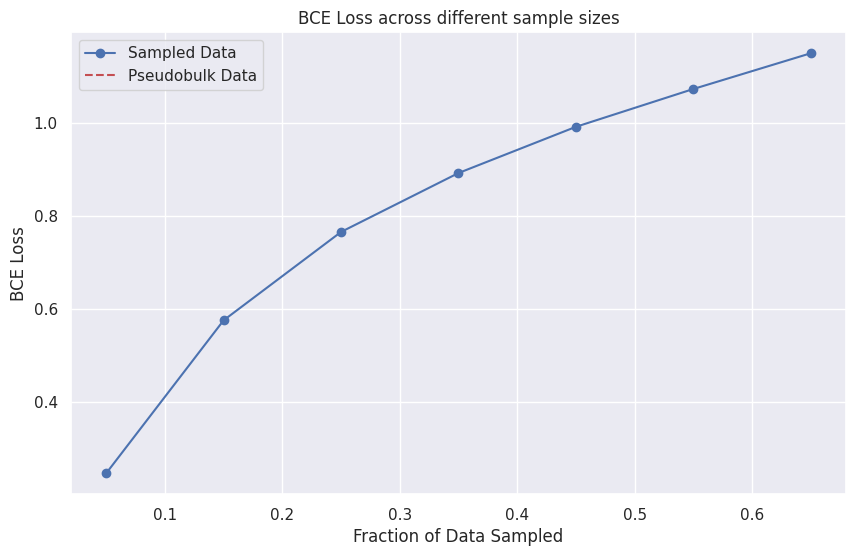

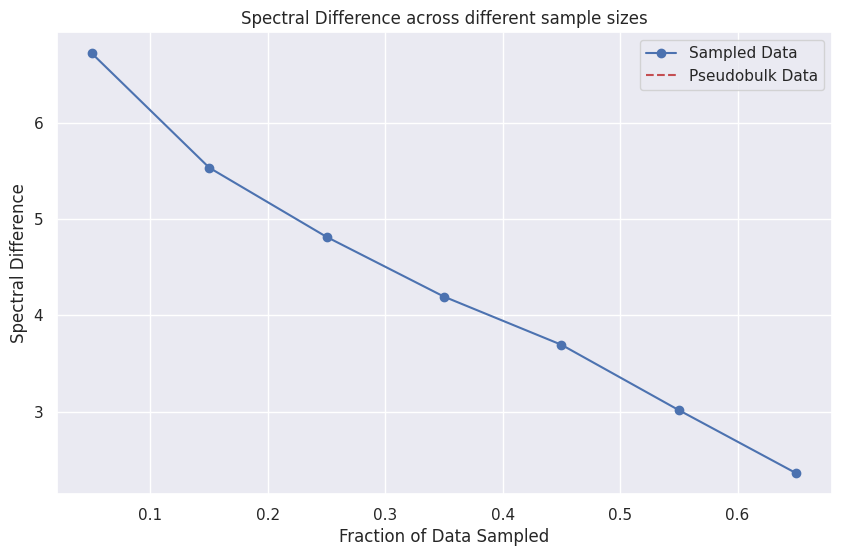

In [52]:
import scanpy as sc
import matplotlib.pyplot as plt

sc.pp.neighbors(adata_tt)


def sample_and_compute_knn(adata, fraction):
    """Sample a fraction of the dataset and compute the KNN graph."""
    sample_size = int(fraction * adata.shape[0])
    sampled_indices = np.random.choice(adata.shape[0], size=sample_size, replace=False)
    sampled_data = adata[sampled_indices]
    sc.pp.neighbors(sampled_data)  # Compute KNN graph
    return sampled_data


# List to store results
results = []

# Sample dataset at intervals from 5% to 70%
fractions = np.arange(0.05, 0.71, 0.10)

for fraction in fractions:
    sampled_adata = sample_and_compute_knn(adata_tt, fraction)
    (
        total_loss,
        bce_loss,
        edge_weight_diff,
        spectral_diff,
    ) = evaluate_reconstruction_sparse(sampled_adata, adata_tt)
    results.append((fraction, bce_loss, spectral_diff))

# Evaluate the pseudobulk_adata
(
    total_loss_pb,
    bce_loss_pb,
    edge_weight_diff_pb,
    spectral_diff_pb,
) = evaluate_reconstruction_sparse(pseudobulk_adata, adata_tt)

# Extracting BCE and spectral difference for plotting
fractions, bce_losses, spectral_diffs = zip(*results)

# Plot BCE loss
plt.figure(figsize=(10, 6))
plt.plot(fractions, bce_losses, "-o", label="Sampled Data")
plt.axhline(y=bce_loss_pb, color="r", linestyle="--", label="Pseudobulk Data")
plt.xlabel("Fraction of Data Sampled")
plt.ylabel("BCE Loss")
plt.legend()
plt.title("BCE Loss across different sample sizes")
plt.show()

# Plot Spectral Difference
plt.figure(figsize=(10, 6))
plt.plot(fractions, spectral_diffs, "-o", label="Sampled Data")
plt.axhline(y=spectral_diff_pb, color="r", linestyle="--", label="Pseudobulk Data")
plt.xlabel("Fraction of Data Sampled")
plt.ylabel("Spectral Difference")
plt.legend()
plt.title("Spectral Difference across different sample sizes")
plt.show()

In [23]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mutual_info_score


def calculate_mutual_information(pc1, pc2):
    """
    Calculate the mutual information between two principal components.
    """
    return mutual_info_score(pc1, pc2)


def calculate_entropy(pc):
    """
    Calculate the entropy of a principal component.
    """
    p_data = pc / np.sum(pc)
    entropy = -np.sum(
        p_data * np.log2(p_data + 1e-12)
    )  # Adding a small value to avoid log(0)
    return entropy


def mutual_information_gap(adata_samp, adata, n_components=10):
    """
    Calculate the Mutual Information Gap (MIG) between the PCs of the sampled data
    and the original data.
    """
    # Align the datasets by selecting the same nodes
    adata = adata[adata_samp.obs.index, :]

    # Write option to detect if PCs already available
    #     # PCA on the sampled data
    #     pca_samp = PCA(n_components=n_components)
    #     pcs_samp = pca_samp.fit_transform(adata_samp.X)

    #     # PCA on the original data
    #     pca = PCA(n_components=n_components)
    #     pcs = pca.fit_transform(adata.X)

    # Calculate mutual information and entropy
    mutual_informations = np.array(
        [
            calculate_mutual_information(pcs_samp[:, i], pcs[:, i])
            for i in range(n_components)
        ]
    )
    entropies = np.array([calculate_entropy(pcs[:, i]) for i in range(n_components)])

    # Normalize mutual information by entropy
    normalized_mi = mutual_informations / entropies

    # Calculate MIG
    mig = (
        np.max(normalized_mi) - np.sort(normalized_mi)[-2]
    )  # Subtract the second highest value from the max

    return mig


# Assuming 'adata_samp' and 'adata' are available Anndata objects with .X as their data matrix
# and they contain the same set of nodes, the following line would calculate MIG:
# mig_result = mutual_information_gap(adata_samp, adata)

In [ ]:
mig_result = mutual_information_gap(adata_samp, adata)

In [254]:
# Which indices are still not within 1 DOF
indices = list(np.where(adata.obs.index.isin(adata_samp.obs.index))[0])
KNN_sm = adata.obsp["connectivities"][indices]
KNN_sm[KNN_sm > 0] = 1
np.sum(KNN_sm, axis=0)
len(np.where(KNN_sm.sum(axis=0) <= 0)[1])

6

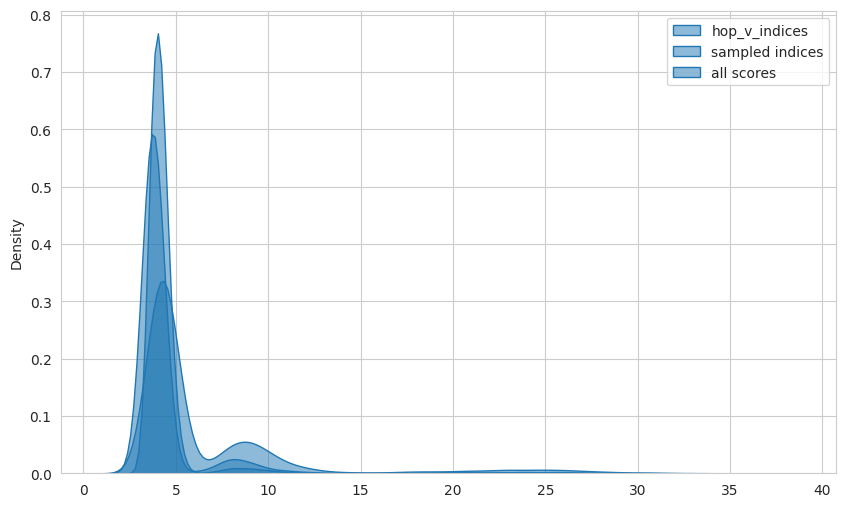

In [278]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset Seaborn style
sns.set_style("whitegrid")

# Define pastel colors
pastel_colors = ["#FFB6C1", "#ADD8E6", "#98FB98"]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot KDE for each distribution with specified pastel colors on the same axis
sns.kdeplot(
    attention_scores[hop_v_indices],
    label="hop_v_indices",
    shade=True,
    alpha=0.5,
    color=pastel_colors[0],
    ax=ax,
)
sns.kdeplot(
    attention_scores[indices],
    label="sampled indices",
    shade=True,
    alpha=0.5,
    color=pastel_colors[1],
    ax=ax,
)
sns.kdeplot(
    attention_scores,
    label="all scores",
    shade=True,
    alpha=0.5,
    color=pastel_colors[2],
    ax=ax,
)

# Display the legend
ax.legend()

# Show the plot
plt.show()

In [294]:
hop_v_stats = {
    "mean": attention_scores[hop_v_indices].mean(),
    "median": np.median(
        attention_scores[hop_v_indices],
    ),
    "75th percentile": np.percentile(attention_scores[hop_v_indices], 75),
    "90th percentile": np.percentile(attention_scores[hop_v_indices], 90),
}
hop_v_stats


sampled_v_stats = {
    "mean": attention_scores[indices].mean(),
    "median": np.median(
        attention_scores[indices],
    ),
    "75th percentile": np.percentile(attention_scores[indices], 75),
    "90th percentile": np.percentile(attention_scores[indices], 90),
}

total_v_stats = {
    "mean": attention_scores.mean(),
    "median": np.median(
        attention_scores,
    ),
    "75th percentile": np.percentile(attention_scores, 75),
    "90th percentile": np.percentile(attention_scores, 90),
}

print("prevously missing_v {}".format(hop_v_stats))
print("sampled_v {}".format(sampled_v_stats))
print("total_v {}".format(total_v_stats))

prevously missing_v {'mean': 4.553032122917516, 'median': 3.8094672777101075, '75th percentile': 4.131890975723265, '90th percentile': 4.859013078389135}
sampled_v {'mean': 6.502188579131575, 'median': 4.528838667138958, '75th percentile': 7.449694765980241, '90th percentile': 10.372208778968822}
total_v {'mean': 4.423070143141681, 'median': 4.089173365468016, '75th percentile': 4.446517630142176, '90th percentile': 4.854599170671179}


# Optional:: Reource usage testing for SGDPR

In [3]:
class ResourceMonitor:
    def __init__(self):
        self.control_queue = Queue()
        self.memory_data = []
        self.cpu_data = []
        self.time_data = []
        self.thread = None

    def monitor_resources(self, interval=1):
        """Monitor system resources at intervals."""
        while True:
            try:
                message = self.control_queue.get(timeout=interval)
                if message == "stop":
                    break
            except Empty:
                pass

            self.memory_data.append(psutil.virtual_memory().used / (1024**2))
            self.cpu_data.append(psutil.cpu_percent(interval=None))
            self.time_data.append(time.time())

    def start_monitoring(self, interval=1):
        """Start the monitoring in a separate thread."""
        self.thread = threading.Thread(target=self.monitor_resources, args=(interval,))
        self.thread.start()

    def stop_monitoring(self):
        """Stop the monitoring."""
        self.control_queue.put("stop")
        if self.thread:
            self.thread.join()


def plot_resources():
    """Plot the collected resource data."""
    plt.figure(figsize=(12, 10))

    # Memory Usage Over Time
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(time_data, memory_data, "-o", color="blue", label="Memory Usage")
    ax1.fill_between(time_data, 0, memory_data, color="blue", alpha=0.3)
    ax1.set_ylim(
        min(memory_data) - 0.1 * min(memory_data),
        max(memory_data) + 0.1 * max(memory_data),
    )

    # Add smoothed spline for memory data
    spl_memory = UnivariateSpline(time_data, memory_data, s=100)
    ax1.plot(
        time_data,
        spl_memory(time_data),
        "k-",
        linewidth=2,
        label="Smoothed Memory Usage",
    )

    ax1.set_title("Memory Usage Over Time")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Memory (MB)")
    ax1.legend()

    # CPU Usage Over Time
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(time_data, cpu_data, "-o", color="red", label="CPU Usage")
    ax2.fill_between(time_data, 0, cpu_data, color="red", alpha=0.3)
    ax2.set_ylim(min(cpu_data) - 5, max(cpu_data) + 5)  # giving a buffer of 5% for CPU
    # Add smoothed spline for CPU data
    spl_cpu = UnivariateSpline(time_data, cpu_data, s=10)
    ax2.plot(
        time_data, spl_cpu(time_data), "k-", linewidth=2, label="Smoothed CPU Usage"
    )

    ax2.set_title("CPU Usage Over Time")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("CPU (%)")
    ax2.legend()

    # Histogram for Memory Usage
    ax3 = plt.subplot(2, 2, 3)
    ax3.hist(memory_data, bins=30, color="blue", alpha=0.7)
    ax3.set_title("Histogram of Memory Usage")
    ax3.set_xlabel("Memory (MB)")
    ax3.set_ylabel("Frequency")

    # Histogram for CPU Usage
    ax4 = plt.subplot(2, 2, 4)
    ax4.hist(cpu_data, bins=30, color="red", alpha=0.7)
    ax4.set_title("Histogram of CPU Usage")
    ax4.set_xlabel("CPU (%)")
    ax4.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [4]:
adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed="r")

Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
pagerank model did not converge during the mini-batch phase
Proceeding on to perform fine-tuning across full-batch


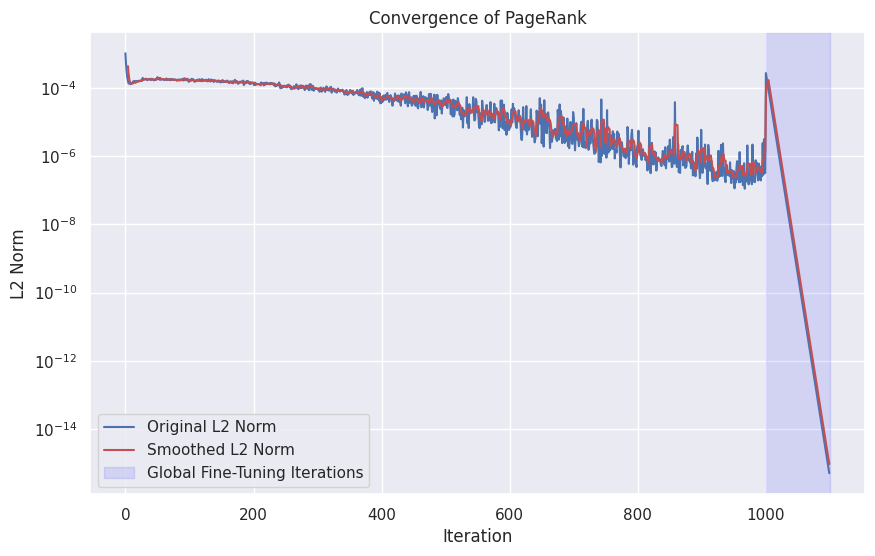

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement


In [5]:
neighborhood_matrix = adata.obsp["connectivities"]
weight_penalty = "laplacian_SGD_pagerank"
if weight_penalty == "laplacian_SGD_pagerank":  # This is essentially an attention score
    print(
        "Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank"
    )
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = (
        np.array(neighborhood_matrix.sum(axis=1)).flatten() + 1
    )  # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    #     # Now you can use normalized_matrix in place of neighborhood_matrix
    #     attention_score = normalized_matrix[indices].sum(axis = 1)
    # Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()


attention_scores, l2_norm_dic = scent.SGDpagerank(
    normalized_matrix,
    num_iterations=1000,
    mini_batch_size=1000,
    initial_learning_rate=0.85,
    tolerance=1e-7,
    d=0.85,
    full_batch_update_iters=100,
    dip_window=5,
    plateau_iterations=5,
    sampling_method="probability_based",
)

In [ ]:
# Create an instance of the ResourceMonitor
monitor = ResourceMonitor()

# Start monitoring
monitor.start_monitoring(interval=1)

SGDpagerank(
    normalized_matrix,
    num_iterations=1000,
    mini_batch_size=1000,
    initial_learning_rate=0.85,
    tolerance=1e-6,
    d=0.85,
    full_batch_update_iters=1000,
    dip_window=5,
    plateau_iterations=5,
    sampling_method="probability_based",
)

# Stop the monitoring
monitor.stop_monitoring()
plot_resources()

In [ ]:
attention_scores, l2_norm_dic = SGDpagerank(
    normalized_matrix,
    num_iterations=1000,
    mini_batch_size=1000,
    initial_learning_rate=0.85,
    tolerance=1e-7,
    d=0.85,
    full_batch_update_iters=100,
    dip_window=5,
    plateau_iterations=5,
    sampling_method="probability_based",
)

In [ ]:
attention_scores

In [ ]:
len(memory_data)

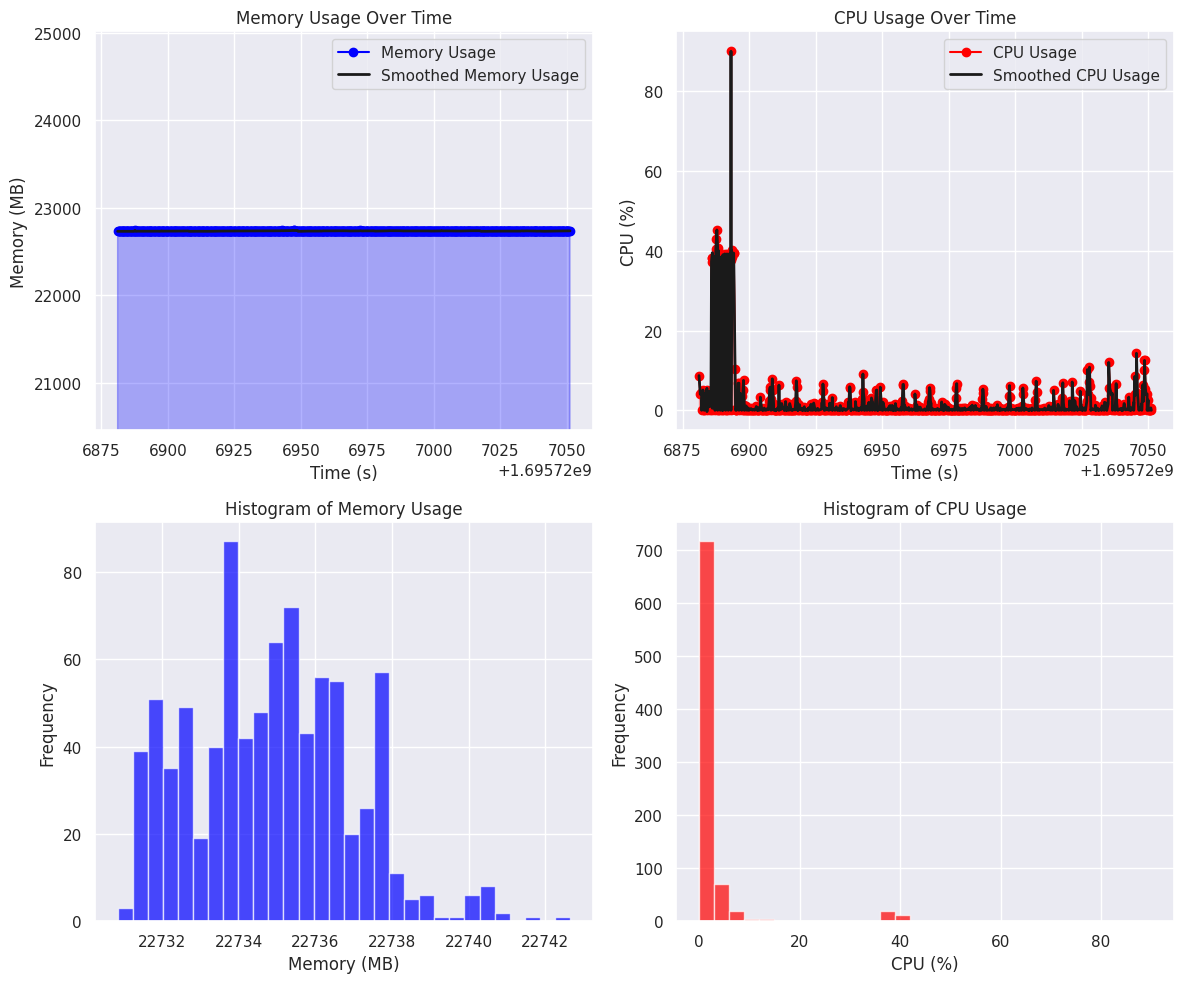

In [66]:
plot_resources()

In [ ]:
hop_v_stats = {
    "mean": attention_scores[hop_v_indices].mean(),
    "median": np.median(
        attention_scores[hop_v_indices],
    ),
    "75th percentile": np.percentile(attention_scores[hop_v_indices], 75),
    "90th percentile": np.percentile(attention_scores[hop_v_indices], 90),
}
hop_v_stats


sampled_v_stats = {
    "mean": attention_scores[indices].mean(),
    "median": np.median(
        attention_scores[indices],
    ),
    "75th percentile": np.percentile(attention_scores[indices], 75),
    "90th percentile": np.percentile(attention_scores[indices], 90),
}

total_v_stats = {
    "mean": attention_scores.mean(),
    "median": np.median(
        attention_scores,
    ),
    "75th percentile": np.percentile(attention_scores, 75),
    "90th percentile": np.percentile(attention_scores, 90),
}

print("prevously missing_v {}".format(hop_v_stats))
print("sampled_v {}".format(sampled_v_stats))
print("total_v {}".format(total_v_stats))

In [ ]:
# Extract the corresponding submatrix from KNN_main
# This step will depend on the specifics of how KNN_sm is a subset of KNN_main
submatrix_main = KNN_main[indices]

# Compute the difference between the matrices
difference = KNN_sm - submatrix_main

# Compute the Frobenius norm of the difference
reconstruction_loss = np.linalg.norm(difference, "fro")

print("Reconstruction Loss:", reconstruction_loss)

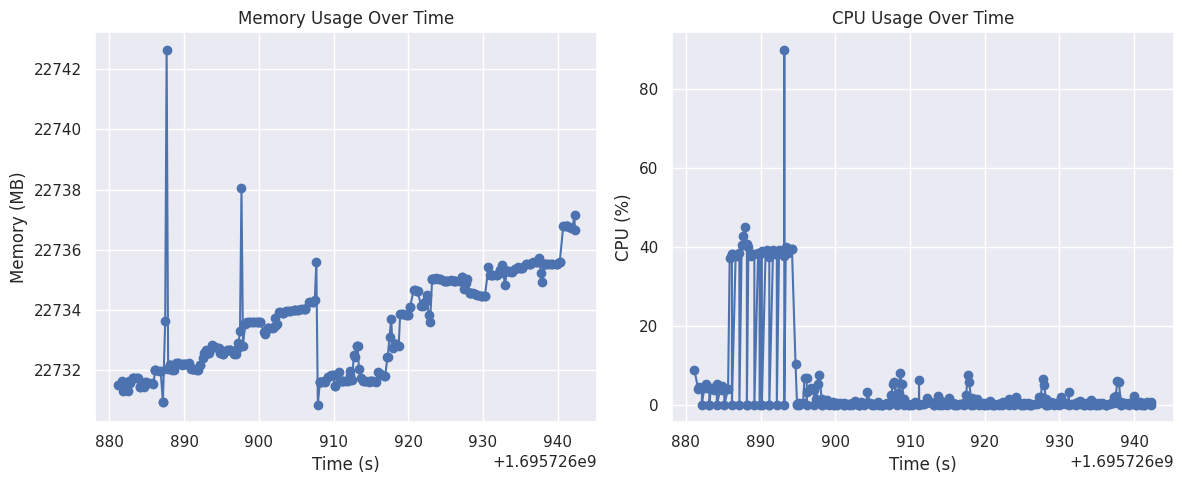

In [60]:
def plot_resources():
    """Plot the collected resource data."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(time_data, memory_data, "-o")
    plt.title("Memory Usage Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Memory (MB)")

    plt.subplot(1, 2, 2)
    plt.plot(time_data, cpu_data, "-o")
    plt.title("CPU Usage Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("CPU (%)")

    plt.tight_layout()
    plt.show()


plot_resources()

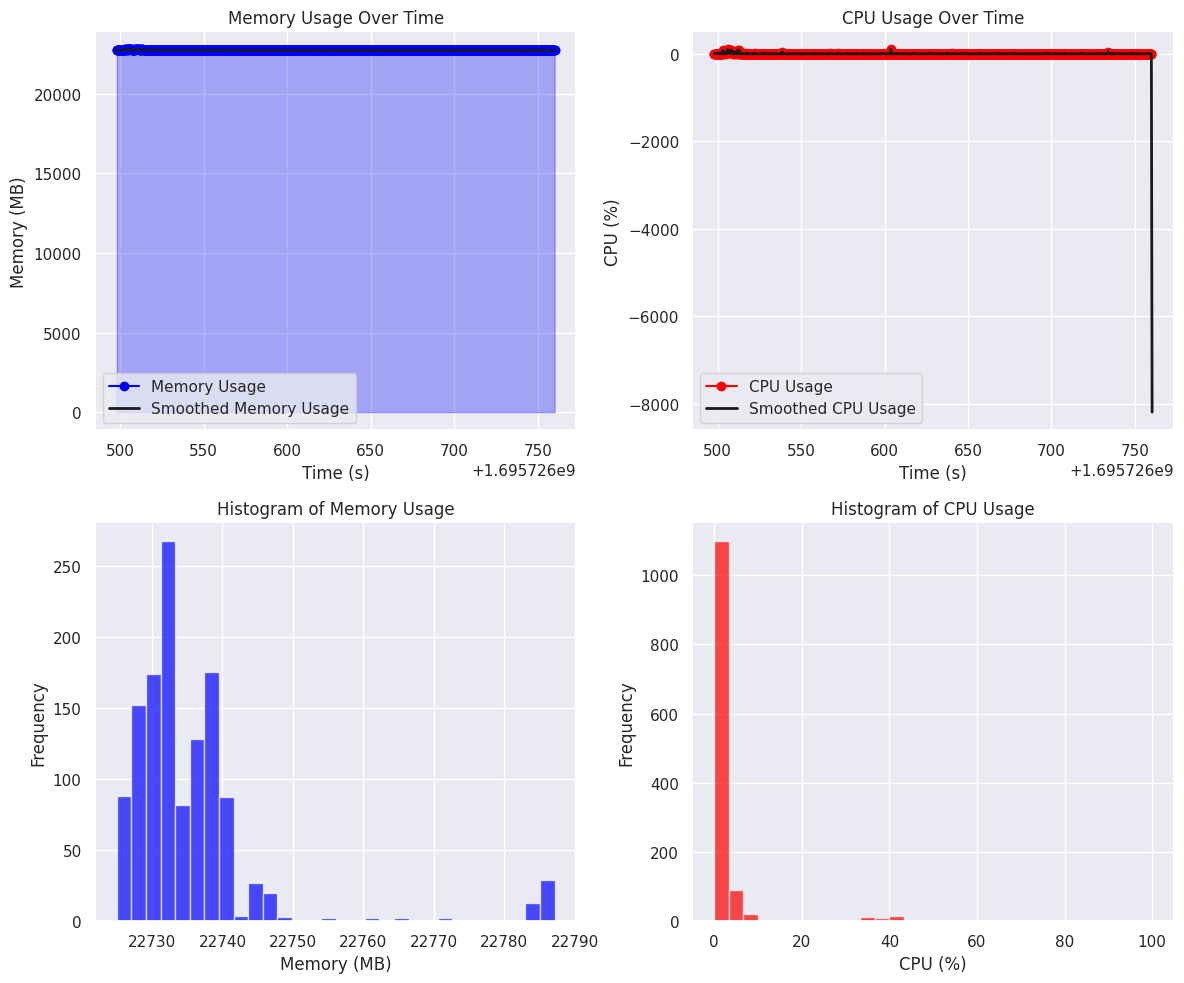

In [56]:
def plot_resources():
    """Plot the collected resource data."""
    plt.figure(figsize=(12, 10))

    # Memory Usage Over Time
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(time_data, memory_data, "-o", color="blue", label="Memory Usage")
    ax1.fill_between(time_data, 0, memory_data, color="blue", alpha=0.3)

    # Add smoothed spline for memory data
    spl_memory = UnivariateSpline(
        time_data, memory_data, s=100
    )  # The 's' parameter determines the amount of smoothing
    ax1.plot(
        time_data,
        spl_memory(time_data),
        "k-",
        linewidth=2,
        label="Smoothed Memory Usage",
    )

    ax1.set_title("Memory Usage Over Time")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Memory (MB)")
    ax1.legend()

    # CPU Usage Over Time
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(time_data, cpu_data, "-o", color="red", label="CPU Usage")
    ax2.fill_between(time_data, 0, cpu_data, color="red", alpha=0.3)

    # Add smoothed spline for CPU data
    spl_cpu = UnivariateSpline(
        time_data, cpu_data, s=10
    )  # The 's' parameter determines the amount of smoothing
    ax2.plot(
        time_data, spl_cpu(time_data), "k-", linewidth=2, label="Smoothed CPU Usage"
    )

    ax2.set_title("CPU Usage Over Time")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("CPU (%)")
    ax2.legend()

    # Histogram for Memory Usage
    ax3 = plt.subplot(2, 2, 3)
    ax3.hist(memory_data, bins=30, color="blue", alpha=0.7)
    ax3.set_title("Histogram of Memory Usage")
    ax3.set_xlabel("Memory (MB)")
    ax3.set_ylabel("Frequency")

    # Histogram for CPU Usage
    ax4 = plt.subplot(2, 2, 4)
    ax4.hist(cpu_data, bins=30, color="red", alpha=0.7)
    ax4.set_title("Histogram of CPU Usage")
    ax4.set_xlabel("CPU (%)")
    ax4.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


plot_resources()

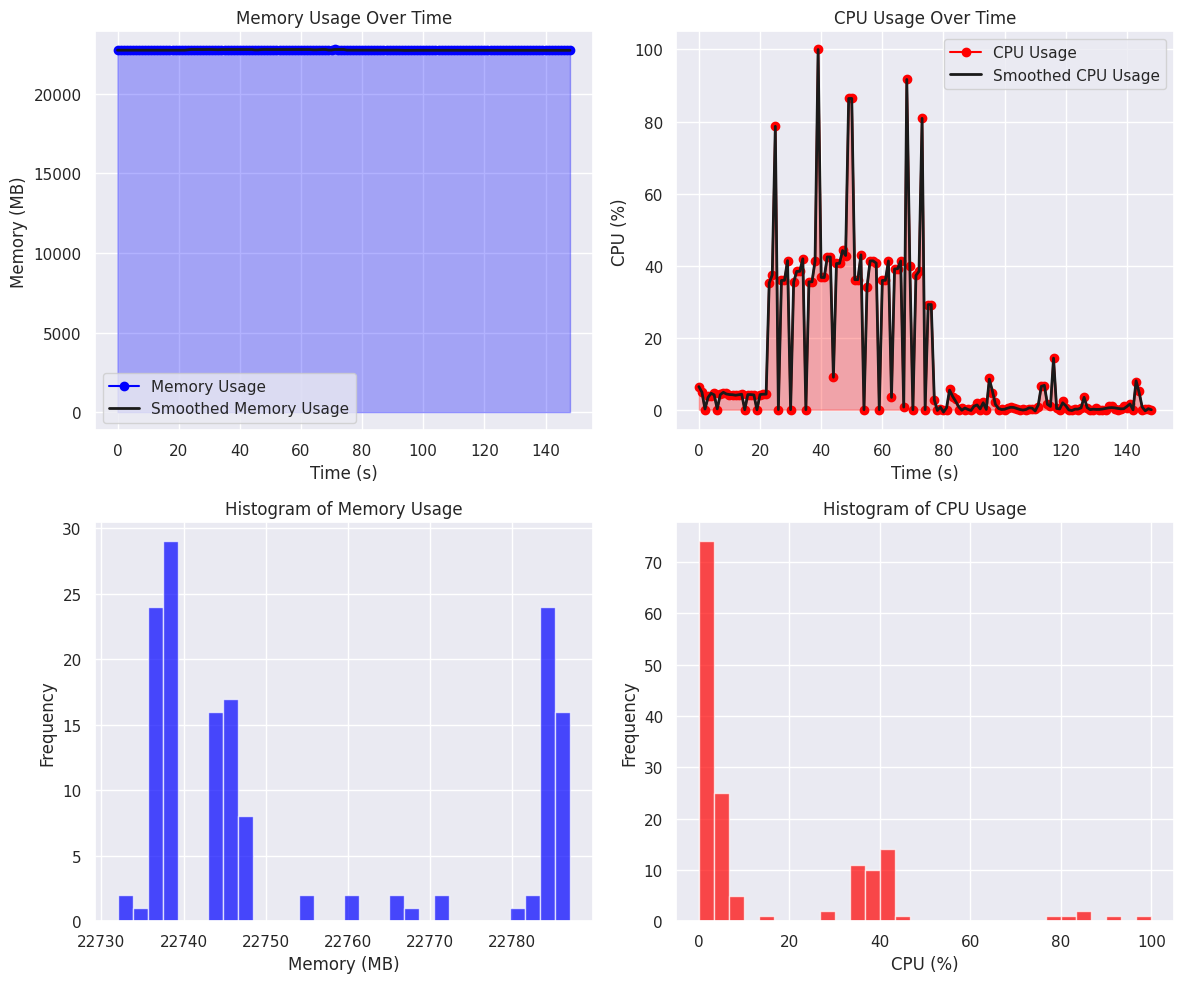

In [50]:
plot_resources()